## Single cell RNA Seq analysis of in vitro induced murine KrasG12D organoids from AT2 cells

## RNA Velocity analysis

### Load packages

In [1]:
# Derived from https://scanpy.readthedocs.io/en/stable/tutorials.html

# Count matrices were generated using CellRanger Count (see 10X Genomics website)

# import packages 
import scanpy.external as sce
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import gprofiler
from seaborn import despine
from seaborn import axes_style
from matplotlib.pyplot import suptitle
import magic # imputation tool; van Dijk et al 2018 # 
import matplotlib.colors
import scvelo as scv

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.6.22.post1 umap==0.3.9 numpy==1.17.2 scipy==1.3.0 pandas==0.23.4 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Making variable names unique for controlled concatenation.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


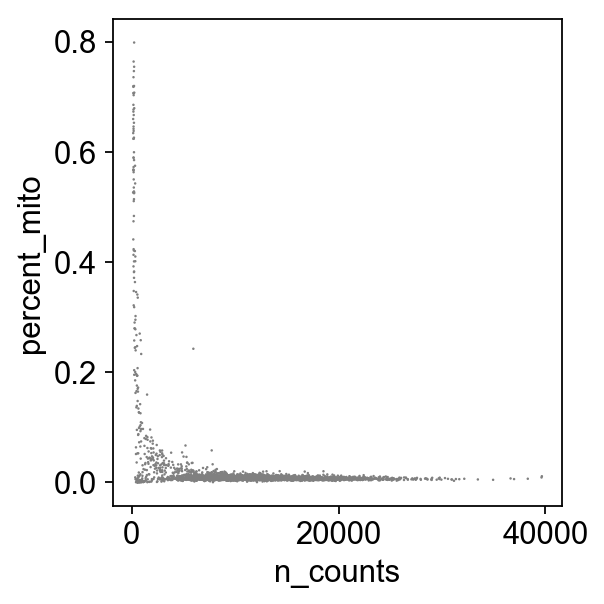

filtered out 12558 genes that are detectedin less than 3 cells


Trying to set attribute `.var` of view, making a copy.


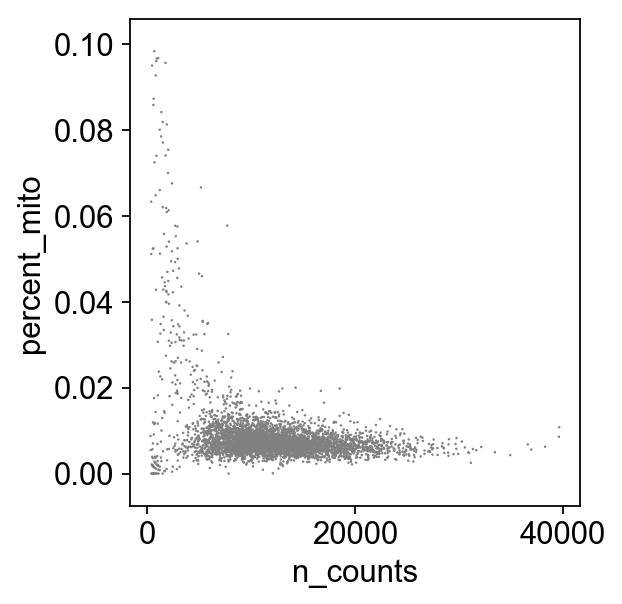

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [2]:
# Velocyto output
filenames_b = [
'./loom_files/DEC13_POOL_ADKYEMP_SI-GA-A8.loom',
'./loom_files/DEC13_POOL_ADKYCRE_SI-GA-A9.loom' 
]

bdatas = [sc.read_loom(filename) for filename in filenames_b]
bdata = bdatas[0].concatenate(bdatas[1:], batch_categories=["KY Empty",'KY Cre'])
bdata.var_names_make_unique() 

# compute %mito and remove cells with >10%
mito_genes = bdata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
bdata.obs['percent_mito'] = np.sum(bdata[:, mito_genes].X, axis=1).A1 / np.sum(bdata.X, axis=1).A1
# add the total counts per cell as observations-annotation to bdata
bdata.obs['n_counts'] = bdata.X.sum(axis=1).A1

# plot mitochondrial content (y-axis) against read count before and after filtering cells with > 10% mitochondrial gene expression
# Cells wth >10% mito expression also has low read count indicating bad/dead cells rather than cells requiring more energy
sc.settings.set_figure_params(dpi=80)
with axes_style({'axes.grid': False}):
 sc.pl.scatter(bdata, y='percent_mito', x='n_counts', size=5)

bdata = bdata[bdata.obs['percent_mito'] < 0.1, :]
sc.pp.filter_genes(bdata, min_cells=3)

with axes_style({'axes.grid': False}):
 sc.pl.scatter(bdata, y='percent_mito', x='n_counts', size=5)

# Normalize the data, save raw data, then use data diffusion tool (van Dijk et al 2018)
sc.pp.normalize_per_cell(bdata)
sc.pp.log1p(bdata)

# No consensus about gene scaling so I did not scale the data. Read https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6582955/
# Not scaling argueable retains biological information
# I did not regress cell cycle either. A population of proliferative or non-proliferative cells in this context would be high interesting in my opinion, and is not information
# I want to remove!

# save current data as bdata.raw
bdata.raw = bdata

computing PCA with n_comps = 50
    finished (0:00:05)


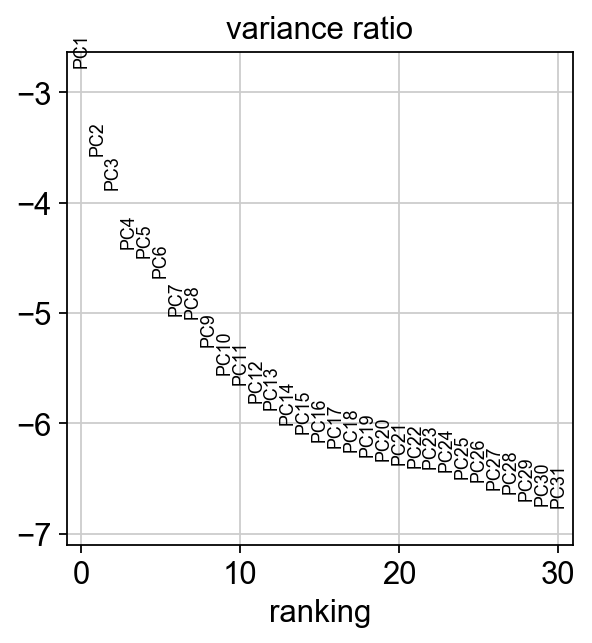

In [3]:
sc.tl.pca(bdata, svd_solver='arpack') # svd_solver='arpack' is important for reproducibility
sc.pl.pca_variance_ratio(bdata, log=True) # find significant pc's

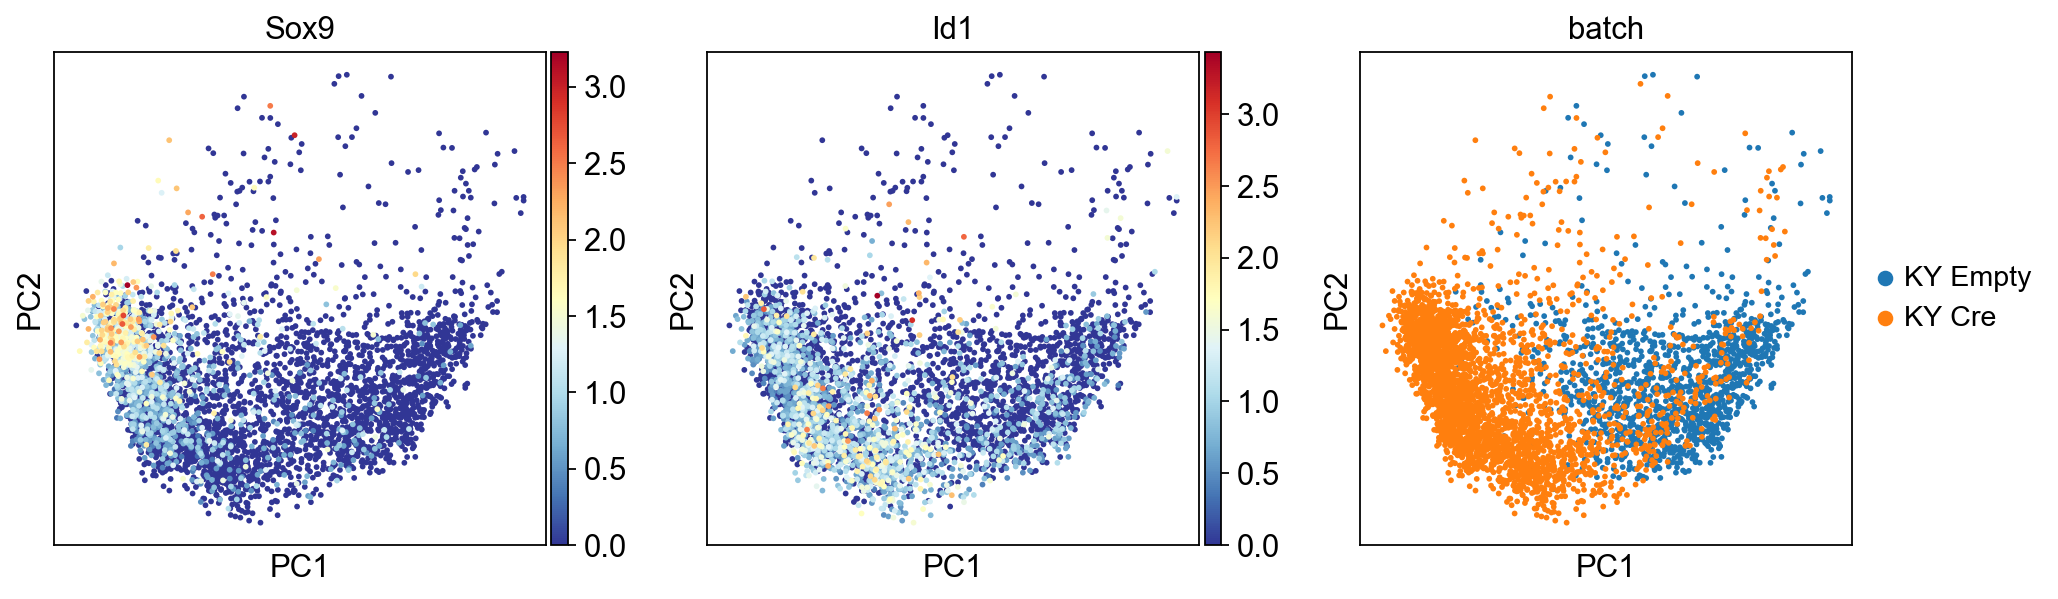

In [4]:
sc.pl.pca(bdata, color=['Sox9','Id1','batch'],color_map='RdYlBu_r')

computing PHATE
    finished (0:00:03)


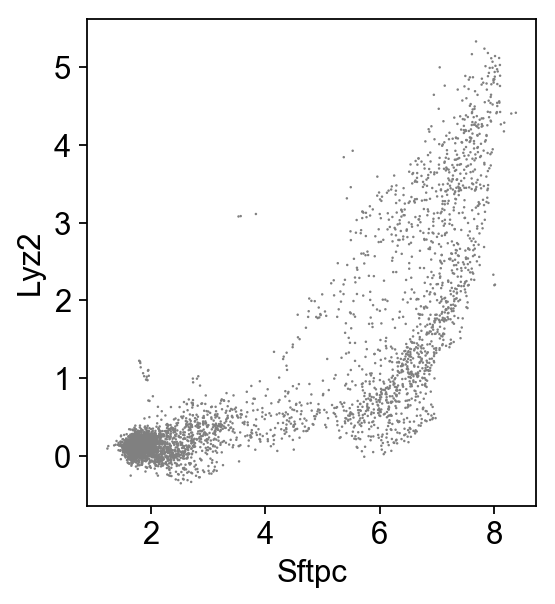

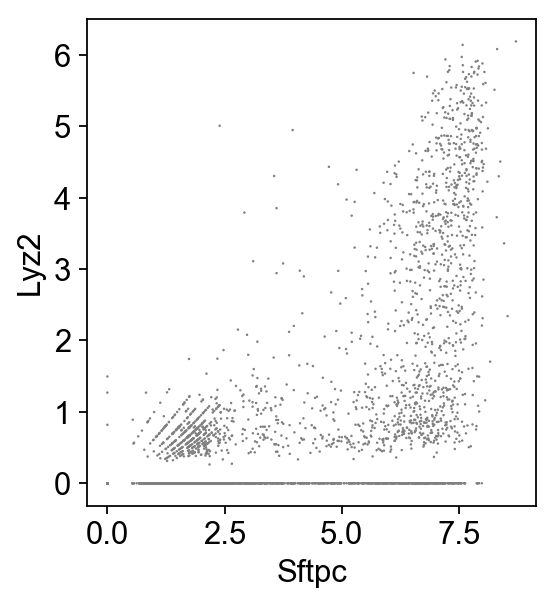

In [5]:
# data diffusion tool is in scanpy.external 
sce.pp.magic(bdata, name_list='all_genes', k=3, t=3, n_pca=30) 

# Compare before and after MAGIC
with axes_style({'axes.grid': False}):
 sc.pl.scatter(bdata, x='Sftpc', y='Lyz2', size=5, use_raw=False, show=False)

with axes_style({'axes.grid': False}):
 sc.pl.scatter(bdata, x='Sftpc', y='Lyz2', size=5, use_raw=True)

In [6]:
# Velocity 

# Pre-process the data 
scv.pp.moments(bdata, n_pcs=30, n_neighbors=50) # 30 is default. More neighbors is useful for larger datasets

# Compute velocity and velocity graph
scv.tl.velocity(bdata)
scv.tl.velocity_graph(bdata)

# Run louvain cluster detection
sc.tl.louvain(bdata, resolution=0.01, key_added='louvain_r0.01')
sc.tl.louvain(bdata, resolution=0.025, key_added='louvain_r0.025')
sc.tl.louvain(bdata, resolution=0.05, key_added='louvain_r0.05')
sc.tl.louvain(bdata, resolution=0.1, key_added='louvain_r0.1')
sc.tl.louvain(bdata, resolution=0.2, key_added='louvain_r0.2')
sc.tl.louvain(bdata, resolution=0.3, key_added='louvain_r0.3')
sc.tl.louvain(bdata, resolution=0.4, key_added='louvain_r0.4')
sc.tl.louvain(bdata, resolution=0.5, key_added='louvain_r0.5')

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:08) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:01:57) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finishe

In [7]:
# Visualize different Louvain resolutions using UMAP
sc.tl.umap(bdata)

computing UMAP
    finished (0:00:11)


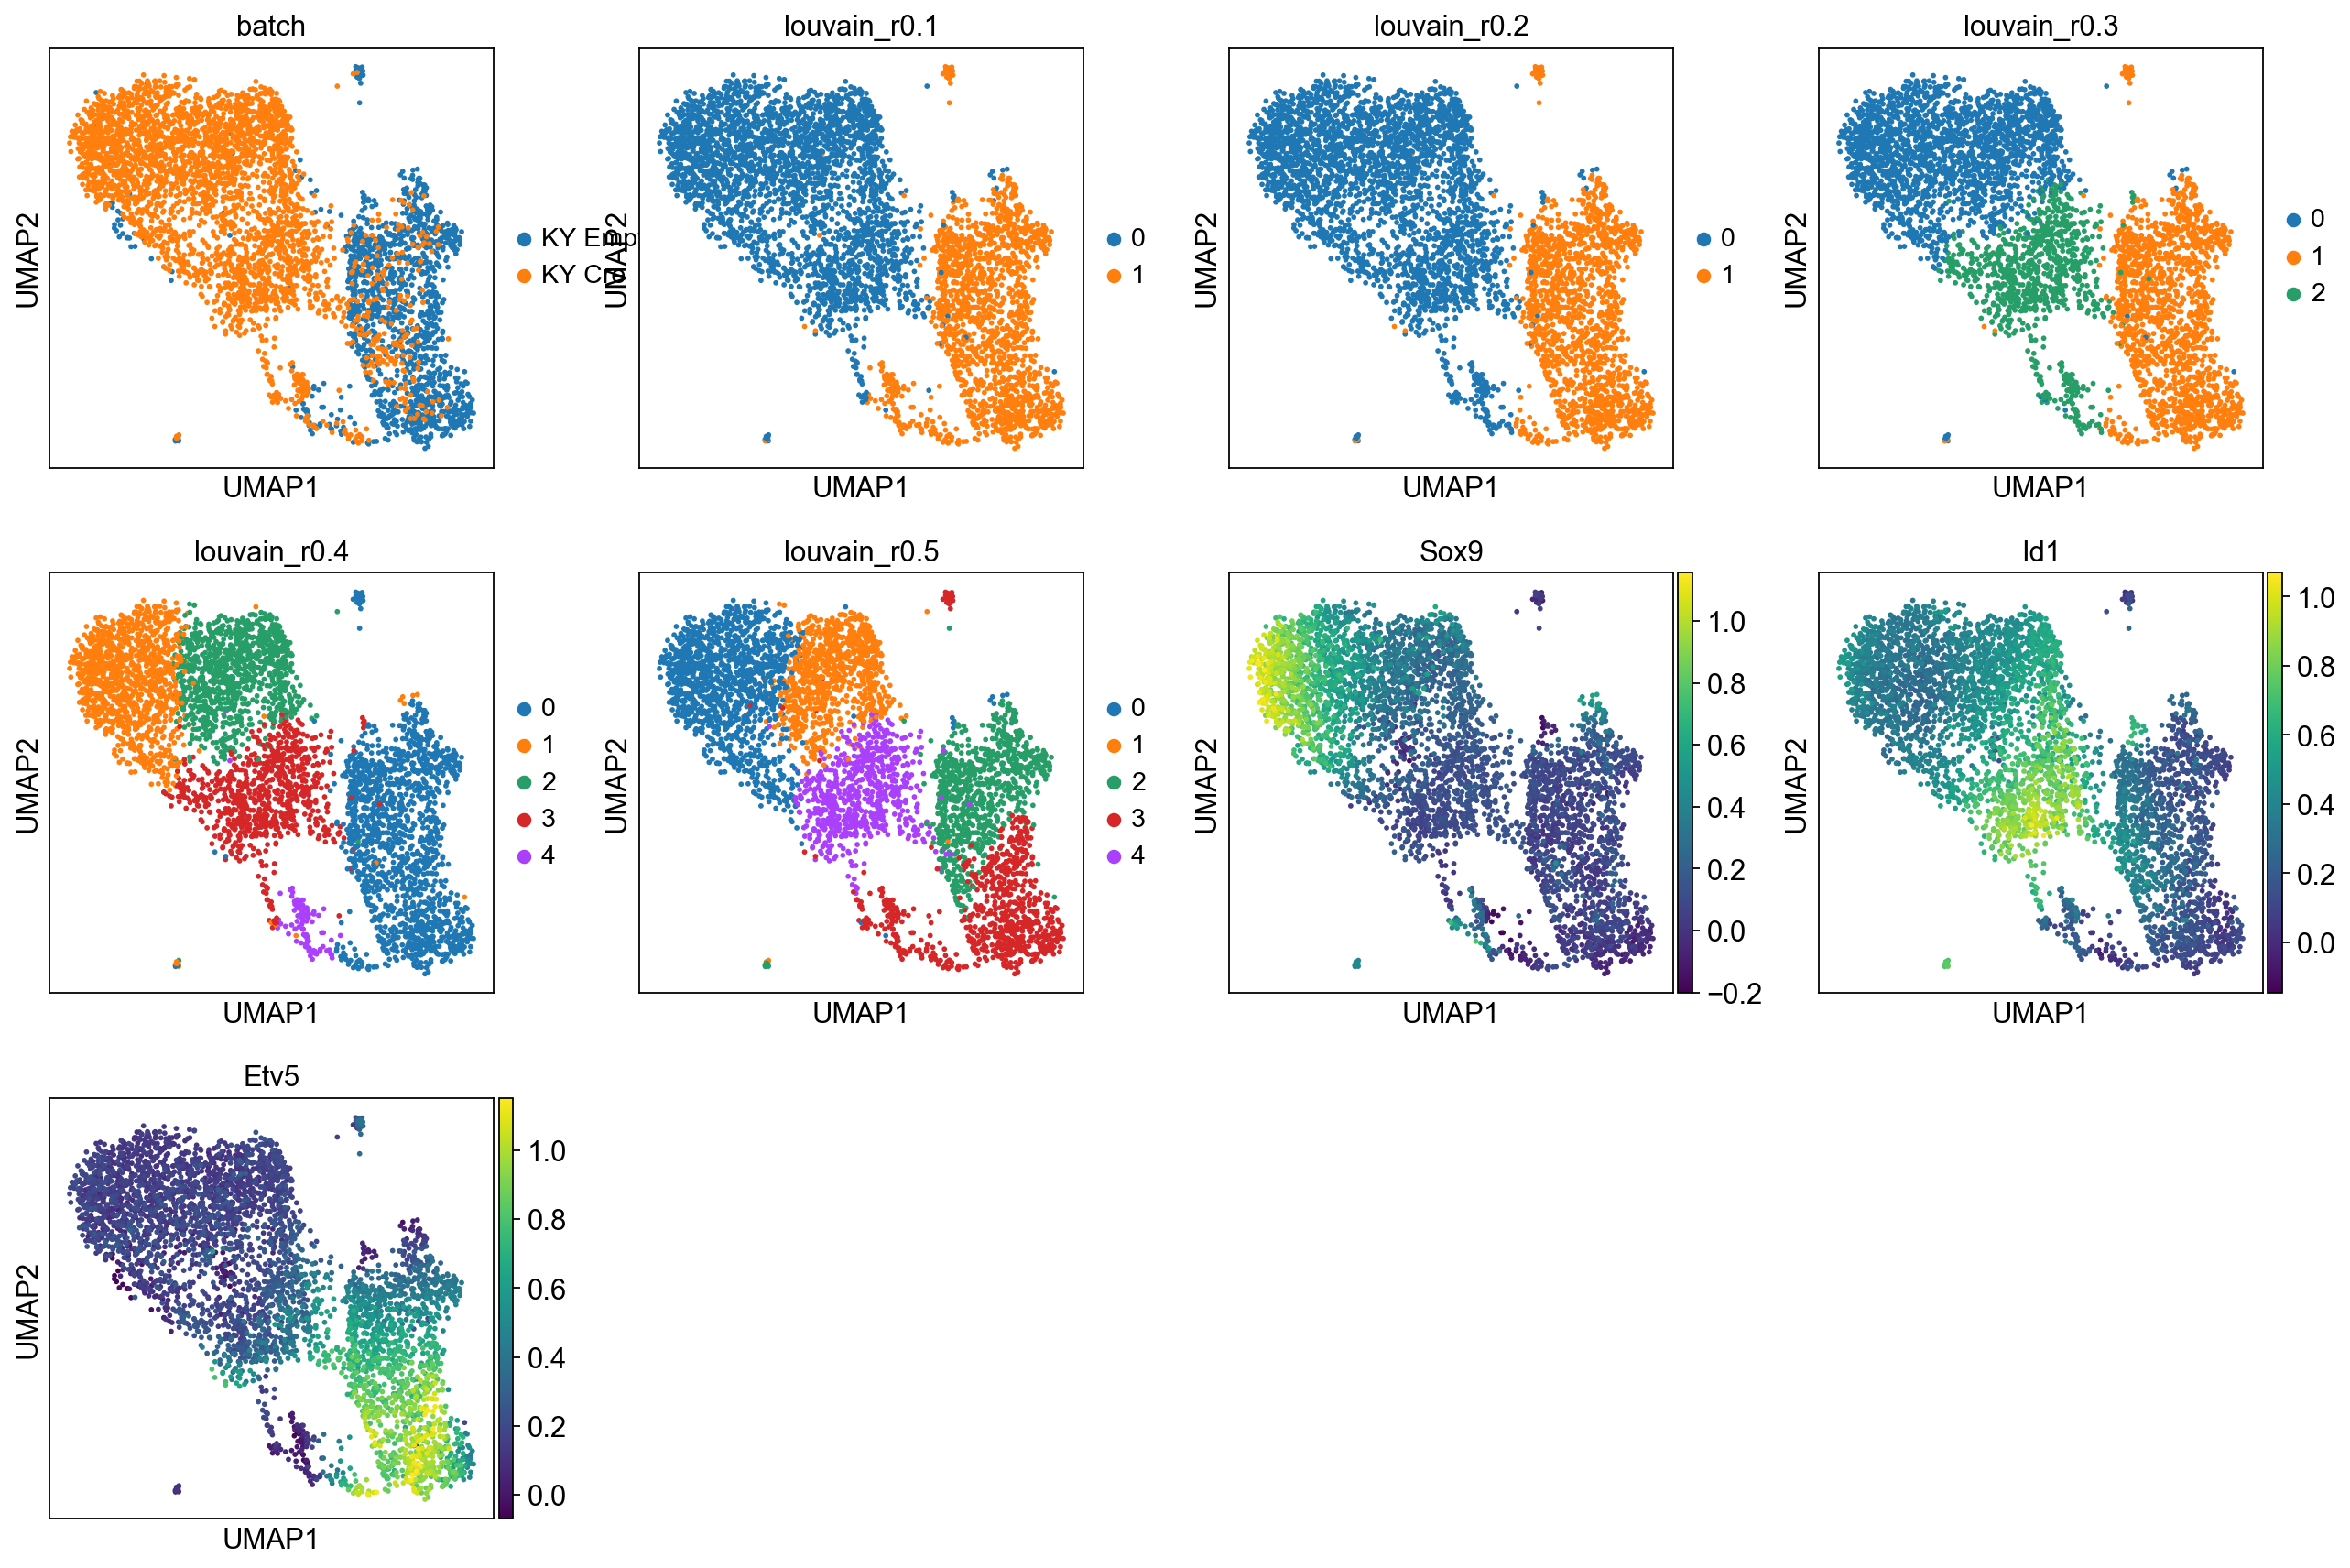

In [10]:
sc.pl.umap(bdata, color=
['batch','louvain_r0.1','louvain_r0.2','louvain_r0.3','louvain_r0.4','louvain_r0.5',
 'Sox9','Id1','Etv5'], use_raw=False)

running PAGA
    finished (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


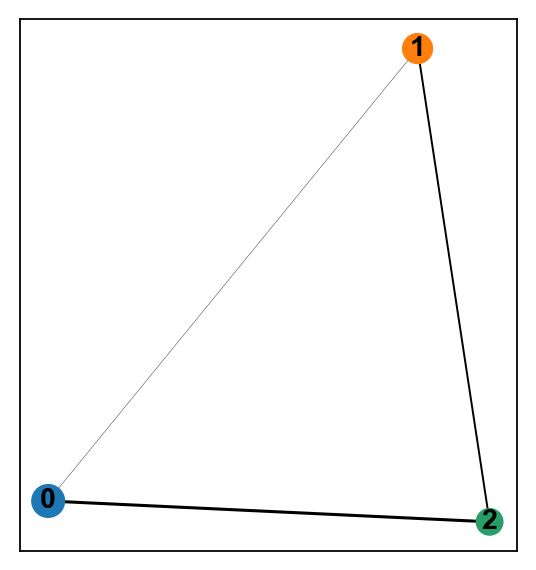

computing UMAP
    finished (0:00:09)


In [11]:
sc.tl.paga(bdata, groups='louvain_r0.3')
sc.pl.paga(bdata, plot=True, color=['louvain_r0.3'])  # remove `plot=False` if you want to see the coarse-grained graph

# sc.tl.umap(adata, init_pos='paga') is not working (August 7, 2019)
# https://github.com/theislab/scanpy/issues/769 = work around for now..
# needs scanpy not scanpy.api
sc.tl.umap(bdata, init_pos=sc.tl._utils.get_init_pos_from_paga(bdata))

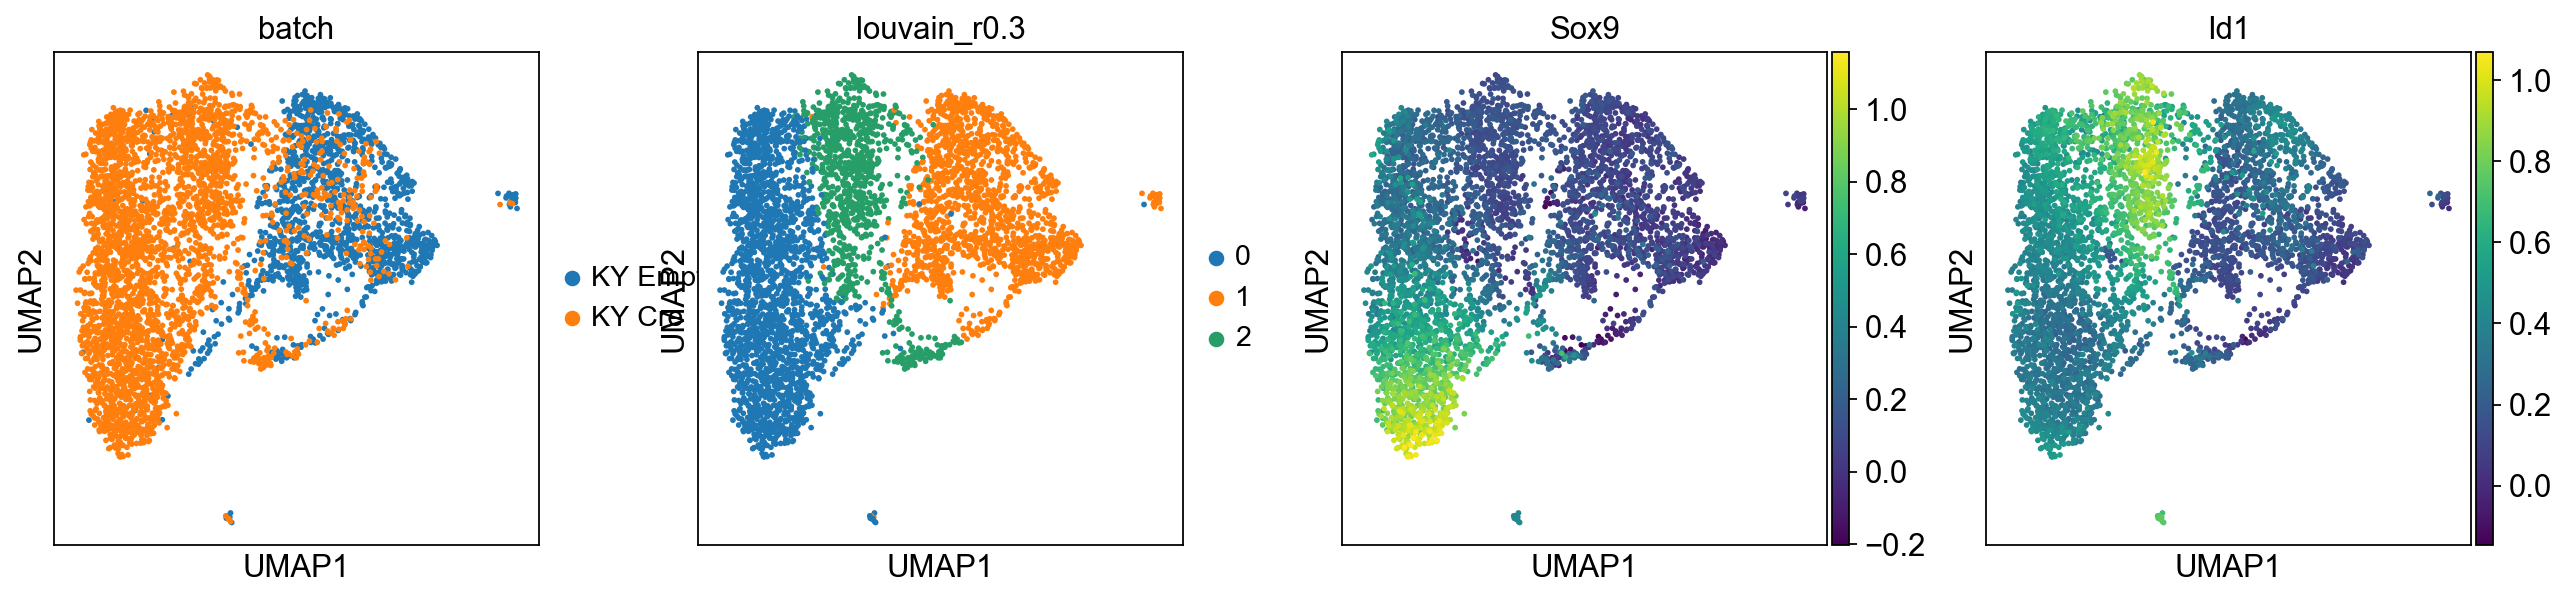

In [12]:
sc.pl.umap(bdata, color=['batch','louvain_r0.3','Sox9','Id1'], use_raw=False)

In [13]:
scv.tl.velocity_embedding(bdata, basis='umap')
# Calculate end point and root cells then visualize
scv.tl.terminal_states(bdata)

computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing terminal states
    identified 3 regions of root cells and 1 region of end points 
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


### Figure 5I

### Visualize velocity data

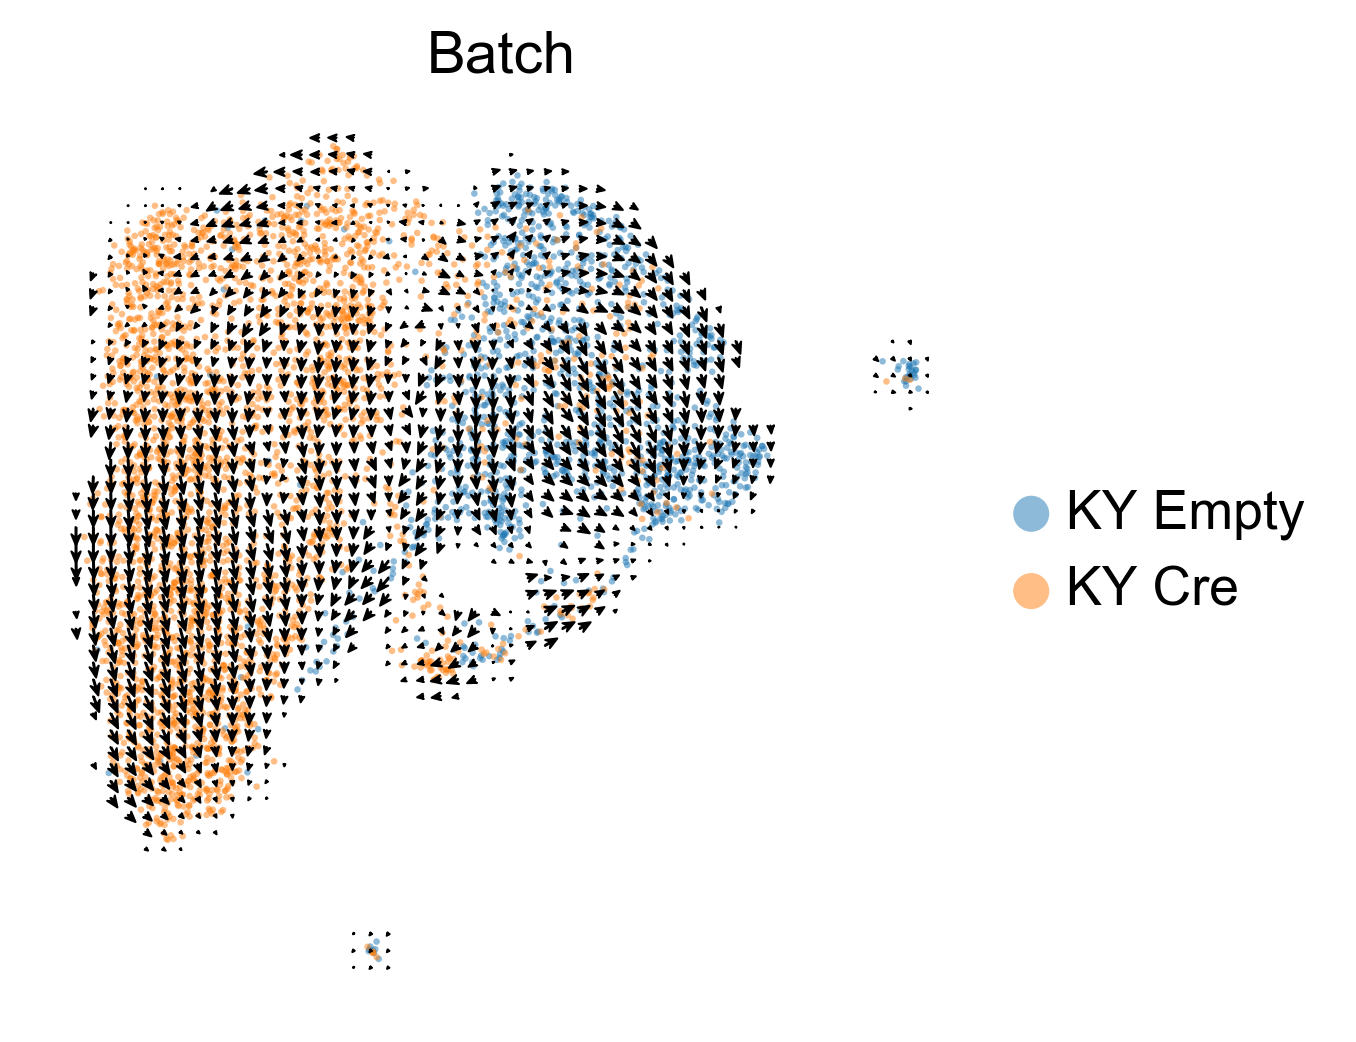

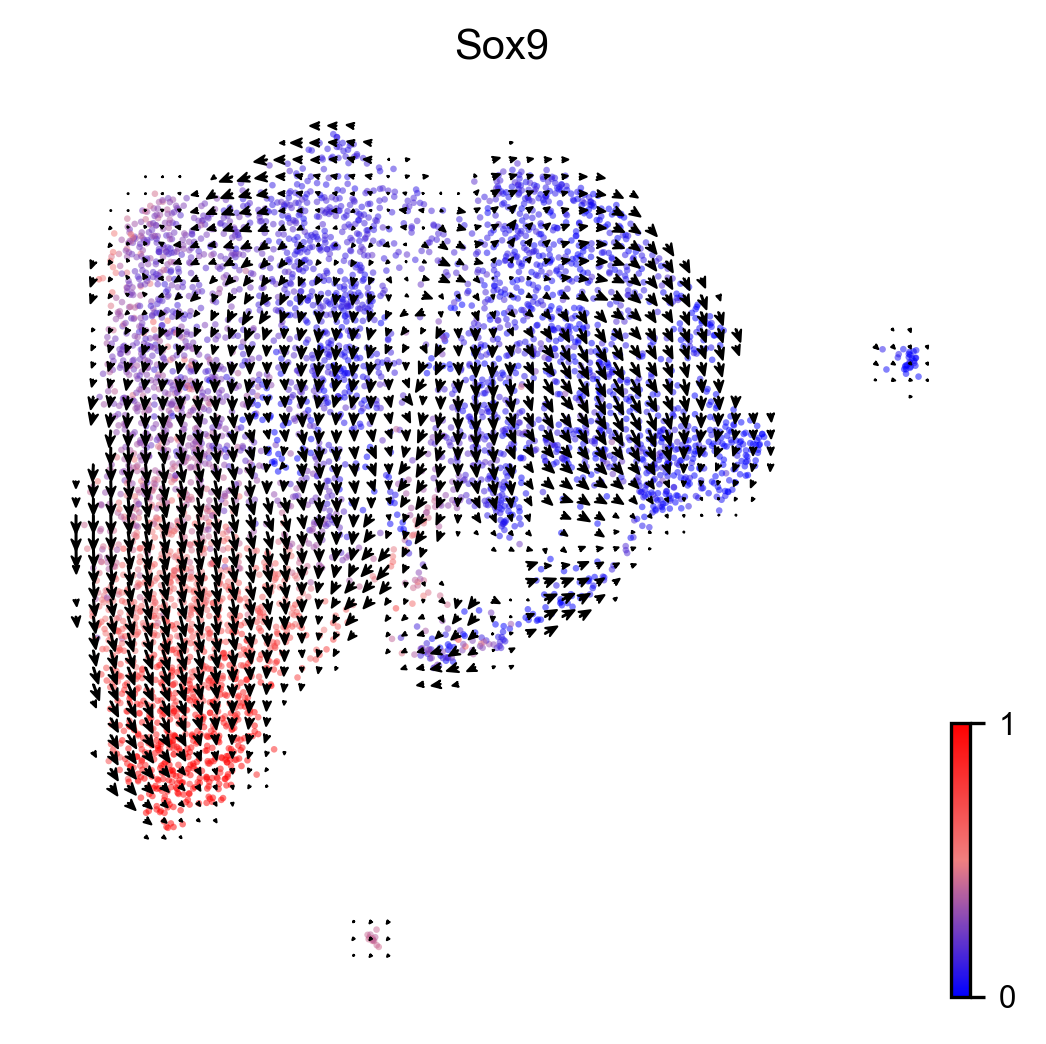

In [14]:
cmap = 'viridis_r'
arrow_color='black'
size=10
vmin=0
figsize=(4,4)
fontsize=14

with axes_style({'axes.grid': False}):
 ax=scv.pl.velocity_embedding_grid(bdata, density=1, basis='umap',arrow_length=2, arrow_size=2, 
 alpha=0.5, color=['batch'], legend_loc='right margin', size=size, ncols=1, 
 figsize=figsize, dpi=(150), frameon=False, color_map=cmap, fontsize=10, 
 arrow_color=arrow_color, linewidth=0.5, title='Batch', show=False)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['blue','lightcoral','red']) 

with axes_style({'axes.grid': False}):
 scv.pl.velocity_embedding_grid(bdata, density=1, basis='umap',arrow_length=2, arrow_size=2, 
 alpha=0.5, color=['Sox9'], vmin=vmin, vmax=1, legend_loc='right margin', size=size, ncols=1, 
 figsize=figsize, dpi=(150), frameon=False, color_map=cmap, fontsize=10, 
 arrow_color=arrow_color, linewidth=0.5, title='Sox9', show=False)
plt.savefig('./figures/umap_sox9.png', bbox_inches='tight')

### Visualize Cre clusters only 

### Figure 5I

In [15]:
# Remove small clusters and save subset data. Save bdata too
cre_results_file = './write/velocity_subset.h5ad'  
bdata_cre = bdata[bdata.obs['louvain_r0.5'].isin(['0','1','4'])]
bdata_cre.write(cre_results_file) # save subset data

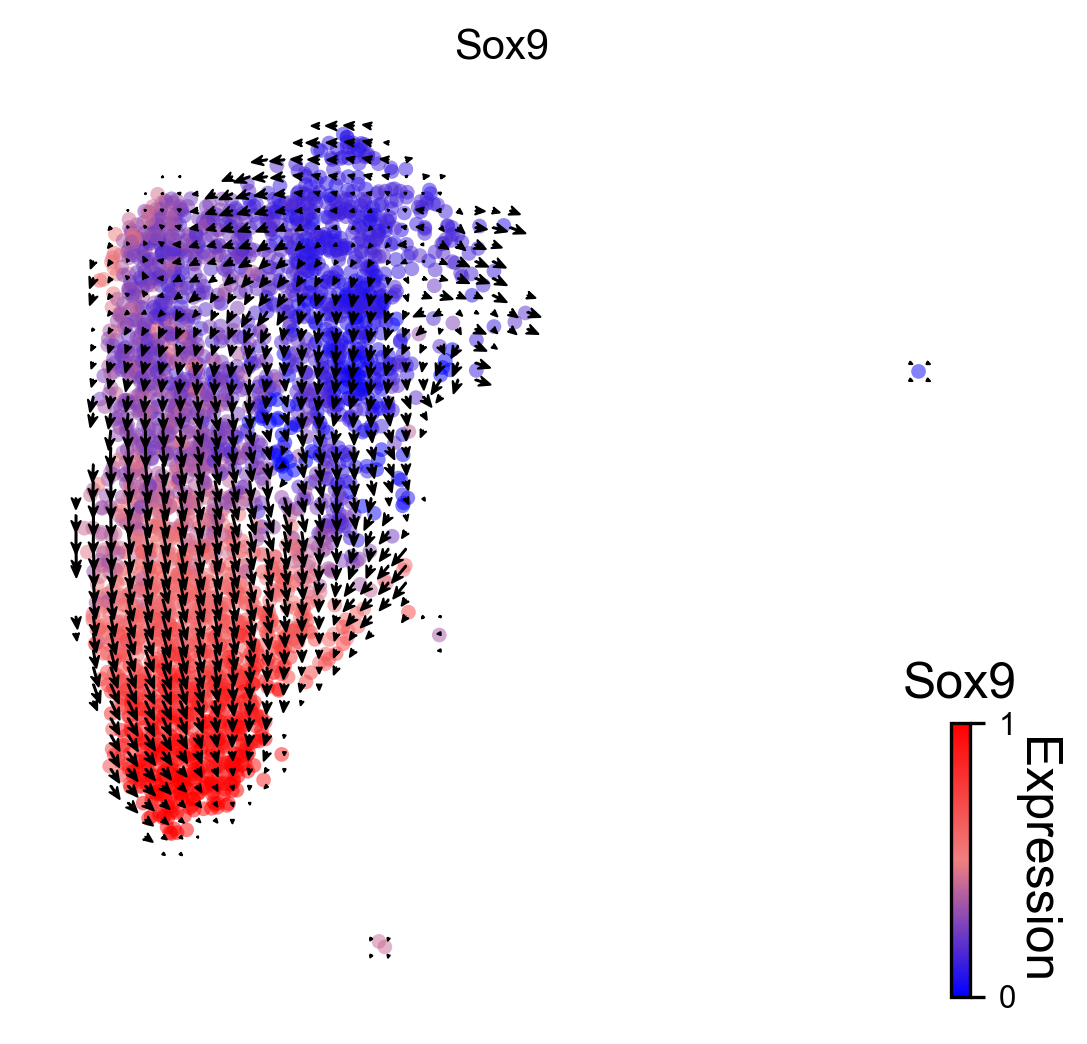

In [16]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['blue','lightcoral','red']) 
#cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['black','red']) 
arrow_color='black'
size=50
vmin=0
figsize=(4,4)
fontsize=14

with axes_style({'axes.grid': False}):
 scv.pl.velocity_embedding_grid(bdata_cre, density=1, basis='umap',arrow_length=2, arrow_size=2, 
 alpha=0.5, color=['Sox9'], vmin=vmin, vmax=1, legend_loc='right margin', size=size, ncols=1, 
 figsize=figsize, dpi=(150), frameon=False, color_map=cmap, fontsize=10, 
 arrow_color=arrow_color, linewidth=0.5, title='Sox9', show=False)
plt.ylabel('Expression', fontsize=12, rotation=270, labelpad=10)
plt.title('Sox9', fontsize=12)
plt.savefig('./figures/umap_creonly_sox9.png', bbox_inches='tight')

### Save

In [17]:
# Create h5ad files to save the data
bdata_results_file = './write/organoid_velocity.h5ad' # all clusters
cre_results_file = './write/organoid_velocity_subset.h5ad'  # cre only clusters

In [18]:
# Save the data
bdata.write(bdata_results_file)
bdata_cre.write(cre_results_file) # save subset data